## Installing requirements



In [24]:
pip install python-dev-tools --user --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


The HDBSCAN library should be installed separately in certain cases to avoid failure. We did not figure out the core reason.

In [26]:
conda install -c conda-forge hdbscan


Note: you may need to restart the kernel to use updated packages.


'conda' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
pip install setuptools --upgrade --user

In [ ]:
pip install bertopic

## Import the words definition and required libraries

In [3]:
import pandas as pd
from bertopic import BERTopic

words = pd.read_csv("./resources/words.csv")
docs = words["Definitions"]

## Structure-based analysis on combinations of algorithms

As part of our structure-based analysis, we compare the average distance to the center of clusters. Note that with algorithis that returns outliers, we do not account for the distance of the outliers.

In [30]:
import numpy as np
from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.decomposition import PCA, TruncatedSVD
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, AgglomerativeClustering

embedding_models = ["all-mpnet-base-v2"]
mapping_methods_name = ["PCA", "UMAP_euclidean", "Truncated_SVD"]
clustering_methods_name = ["HDBSCAN", "K_means_100", "Agglomerative_100"]
#Topic representation not tested yet

SEED = 100

mapping_methods = [PCA(n_components=5),
                   UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='euclidean'),
                   TruncatedSVD(n_components=5)]

clustering_methods = [
    HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    KMeans(n_clusters=100),
    AgglomerativeClustering(n_clusters=100)
]
np.random.seed(SEED)

results = pd.DataFrame({"Embedding model": [], "Mapping method" : [], "Clustering method": [], "Average distances to center": [], "Average for each clusters" : [], "Outlier": []})

import itertools
for (embedding_model, mapping_methods_index, clustering_methods_index) in itertools.product(embedding_models, range(3), range(3)):
    print(f"Trial - Emdedding model: {embedding_model} - Mapping Method: {mapping_methods_name[mapping_methods_index]} - Clustering Method: {clustering_methods_name[clustering_methods_index]}")
    sentence_model = SentenceTransformer(embedding_model)
    embeddings = sentence_model.encode(docs, show_progress_bar=False)

    topic_model = BERTopic(hdbscan_model=clustering_methods[clustering_methods_index],
                           embedding_model=sentence_model,
                           umap_model=mapping_methods[mapping_methods_index])
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    topic_embeddings = topic_model.topic_embeddings_
    docs_embeddings = embeddings

    have_outliers = int(-1 in topics) #This will be 1 if there is an outlier topic, just to cope with how topic_model.topic_embeddings_ is

    topics = np.array(topics)
    valid_points_mask = (topics != -1)
    valid_points = docs_embeddings[valid_points_mask]
    valid_assignments = topics[valid_points_mask]
    # Calculate the distances for each valid point to its assigned cluster center
    distances = np.linalg.norm(valid_points - topic_embeddings[valid_assignments + have_outliers], axis=1)
    # Calculate the average distance for each cluster
    average_distances = np.zeros(len(topic_embeddings)-have_outliers)
    count_per_cluster = np.zeros(len(topic_embeddings)-have_outliers)
    for i in range(len(valid_assignments)):
        cluster_idx = valid_assignments[i]
        average_distances[cluster_idx] += distances[i]
        count_per_cluster[cluster_idx] += 1
    # Avoid division by zero
    count_per_cluster[count_per_cluster == 0] = 1
    average_distances /= count_per_cluster

    results = results._append({"Embedding model": embedding_model, "Mapping method" : mapping_methods_name[mapping_methods_index], "Clustering method": clustering_methods_name[clustering_methods_index], "Average distances to center": np.average(distances), "Average for each clusters" : np.average(average_distances), "Outlier": have_outliers}, ignore_index=True)
results.to_csv("./results/structure_based.csv")


Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: PCA - Clustering Method: HDBSCAN
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: PCA - Clustering Method: K_means_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: PCA - Clustering Method: Agglomerative_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: UMAP_euclidean - Clustering Method: HDBSCAN
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: UMAP_euclidean - Clustering Method: K_means_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: UMAP_euclidean - Clustering Method: Agglomerative_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: Truncated_SVD - Clustering Method: HDBSCAN
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: Truncated_SVD - Clustering Method: K_means_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: Truncated_SVD - Clustering Met

In [31]:
results 

,Embedding model,Mapping method,Clustering method,Average distances to center,Average for each clusters,Outlier
0,multi-qa-MiniLM-L6-dot-v1,PCA,HDBSCAN,3.620971,3.763222,1.0
1,multi-qa-MiniLM-L6-dot-v1,PCA,K_means_100,3.904572,3.907033,0.0
2,multi-qa-MiniLM-L6-dot-v1,PCA,Agglomerative_100,3.922266,3.902737,0.0
3,multi-qa-MiniLM-L6-dot-v1,UMAP_euclidean,HDBSCAN,3.609826,3.480392,1.0
4,multi-qa-MiniLM-L6-dot-v1,UMAP_euclidean,K_means_100,3.697299,3.571187,0.0
5,multi-qa-MiniLM-L6-dot-v1,UMAP_euclidean,Agglomerative_100,3.705799,3.586600,0.0
6,multi-qa-MiniLM-L6-dot-v1,Truncated_SVD,HDBSCAN,4.257888,3.888357,1.0
7,multi-qa-MiniLM-L6-dot-v1,Truncated_SVD,K_means_100,3.950982,3.917838,0.0
8,multi-qa-MiniLM-L6-dot-v1,Truncated_SVD,Agglomerative_100,3.959309,3.936597,0.0


Noted that UMAP_eulidean g

## Baseline for human-based analysis.

### Hyperparameter tuning

For human-based analysis, as advised, we tried the PCA and K-means clustering algorithms as our baseline.

We take from the lectures that the percentage of variance kept with PCA dimensions is porportional to the eigenvalues of the data's covariance valuesmatrix. That said, we plot the elbow curve for PCA from such eigenvalues:

In [39]:
sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(embeddings)
embeddings_std = sc.transform(embeddings)

from numpy.linalg import eigh
cov_matrix = np.cov(embeddings_std, rowvar=False)
egnvalues, egnvectors = eigh(cov_matrix)
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]
cum_sum_exp = np.cumsum(var_exp)


from kneed import KneeLocator
kneedle = KneeLocator(range(0,len(cum_sum_exp)), cum_sum_exp, S=1.0, curve="concave", direction="increasing", interp_method="interp1d")

print(round(kneedle.knee, 3))
print(round(kneedle.elbow, 3))

182
182


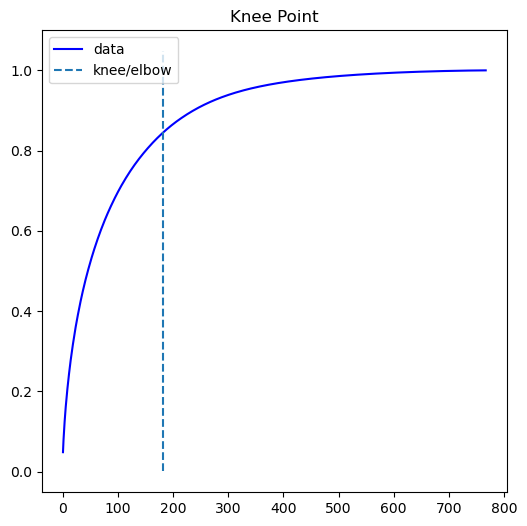

In [38]:
kneedle.plot_knee()

In [46]:
kneedle.knee_y

0.8454826139910995

In [118]:
embeddings.shape

(3804, 768)

The elbow point for PCA dimensionality reduction is at 182 dimensions, keeping 85% of total variance.

For our first trial, we run K-means and measure specific scores (average distance, squared distance, silhouette scores) with the original, non-flattened data over the number of clusters k.

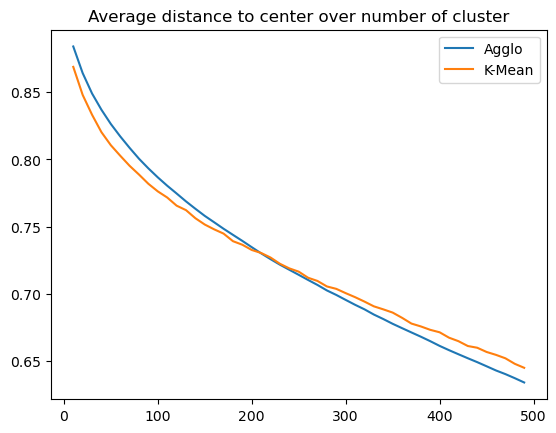

In [3]:
import numpy as np
from bertopic.dimensionality import BaseDimensionalityReduction
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.cluster import KMeans, AgglomerativeClustering

embedding_models = ["all-mpnet-base-v2"]

#Topic representation not tested yet

SEED = 100

np.random.seed(SEED)

sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

average_distances_for_each_try_agglo = []
average_distances_for_each_try_kmeans = []

for n_cluster in range(10, 500, 10):
    clustering_method = AgglomerativeClustering(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    topic_embeddings = topic_model.topic_embeddings_
    docs_embeddings = embeddings

    have_outliers = int(-1 in topics) #This will be 1 if there is an outlier topic, just to cope with how topic_model.topic_embeddings_ is

    topics = np.array(topics)
    valid_points_mask = (topics != -1)
    valid_points = docs_embeddings[valid_points_mask]
    valid_assignments = topics[valid_points_mask]
    # Calculate the distances for each valid point to its assigned cluster center
    distances = np.linalg.norm(valid_points - topic_embeddings[valid_assignments + have_outliers], axis=1)
    # Calculate the average distance for each cluster
    average_distances = np.zeros(len(topic_embeddings)-have_outliers)
    count_per_cluster = np.zeros(len(topic_embeddings)-have_outliers)
    for i in range(len(valid_assignments)):
        cluster_idx = valid_assignments[i]
        average_distances[cluster_idx] += distances[i]
        count_per_cluster[cluster_idx] += 1
    # Avoid division by zero
    count_per_cluster[count_per_cluster == 0] = 1
    average_distances /= count_per_cluster

    average_distances_for_each_try_agglo.append(np.average(distances))


for n_cluster in range(10, 500, 10):
    clustering_method = KMeans(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    topic_embeddings = topic_model.topic_embeddings_ #for every topic there is one vector
    docs_embeddings = embeddings

    have_outliers = int(-1 in topics) #This will be 1 if there is an outlier topic, just to cope with how topic_model.topic_embeddings_ is

    topics = np.array(topics)
    valid_points_mask = (topics != -1) #leaving -1 out
    valid_points = docs_embeddings[valid_points_mask]
    valid_assignments = topics[valid_points_mask]
    # Calculate the distances for each valid point to its assigned cluster center
    
    distances = np.linalg.norm(valid_points - topic_embeddings[valid_assignments + have_outliers], axis=1) 
    #Note: modify the distances vector for different metrices
    
    # Calculate the average distance for each cluster
    average_distances = np.zeros(len(topic_embeddings)-have_outliers)
    count_per_cluster = np.zeros(len(topic_embeddings)-have_outliers)
    for i in range(len(valid_assignments)):
        cluster_idx = valid_assignments[i]
        average_distances[cluster_idx] += distances[i]
        count_per_cluster[cluster_idx] += 1
    # Avoid division by zero
    count_per_cluster[count_per_cluster == 0] = 1
    average_distances /= count_per_cluster

    average_distances_for_each_try_kmeans.append(np.average(distances))


import matplotlib.pyplot as plt 

plt.plot(range(10, 500, 10), average_distances_for_each_try_agglo, label = "Agglo")
plt.plot(range(10, 500, 10), average_distances_for_each_try_kmeans, label = "K-Mean")
plt.title("Average distance to center over number of cluster") 
plt.legend()
plt.show()


kmean -  1610
kmean -  1620
kmean -  1630
kmean -  1640
kmean -  1650
kmean -  1660
kmean -  1670
kmean -  1680
kmean -  1690
kmean -  1700
kmean -  1710
kmean -  1720
kmean -  1730
kmean -  1740
kmean -  1750
kmean -  1760
kmean -  1770
kmean -  1780
kmean -  1790
kmean -  1800
kmean -  1810
kmean -  1820
kmean -  1830
kmean -  1840
kmean -  1850
kmean -  1860
kmean -  1870
kmean -  1880
kmean -  1890
kmean -  1900
kmean -  1910
kmean -  1920
kmean -  1930
kmean -  1940
kmean -  1950
kmean -  1960
kmean -  1970
kmean -  1980
kmean -  1990
kmean -  2000
kmean -  2010
kmean -  2020
kmean -  2030
kmean -  2040
kmean -  2050
kmean -  2060
kmean -  2070
kmean -  2080
kmean -  2090
kmean -  2100
kmean -  2110
kmean -  2120
kmean -  2130
kmean -  2140
kmean -  2150
kmean -  2160
kmean -  2170
kmean -  2180
kmean -  2190
kmean -  2200
kmean -  2210
kmean -  2220
kmean -  2230
kmean -  2240
kmean -  2250
kmean -  2260
kmean -  2270
kmean -  2280
kmean -  2290
kmean -  2300
kmean -  2310
kmean 

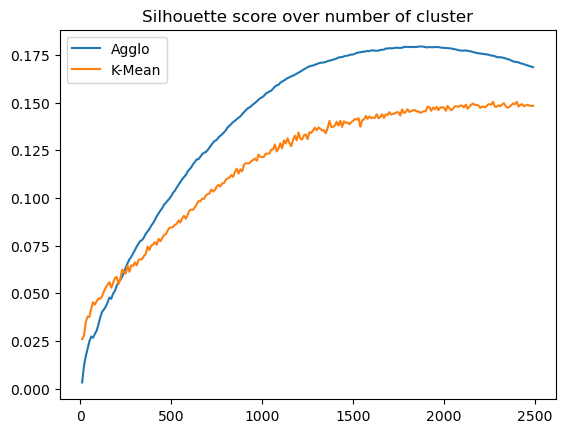

In [7]:
import numpy as np
from bertopic.dimensionality import BaseDimensionalityReduction
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

embedding_models = ["all-mpnet-base-v2"]

#Topic representation not tested yet

SEED = 100

np.random.seed(SEED)

sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

silhouette_for_each_try_agglo = []
silhouette_for_each_try_kmeans = []

for n_cluster in range(10, 2500, 10):
    clustering_method = AgglomerativeClustering(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    topics = np.array(topics)
    silhouette_for_each_try_agglo.append(silhouette_score(embeddings, topics))


for n_cluster in range(1610, 2500, 10):
    print("kmean - ", n_cluster)
    clustering_method = KMeans(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    topics = np.array(topics)
    silhouette_for_each_try_kmeans.append(silhouette_score(embeddings, topics))
    


import matplotlib.pyplot as plt 

plt.plot(range(10, 2500, 10), silhouette_for_each_try_agglo, label = "Agglo")
plt.plot(range(10, 2500, 10), silhouette_for_each_try_kmeans, label = "K-Mean")
plt.title("Silhouette score over number of cluster") 
plt.legend()
plt.show()


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


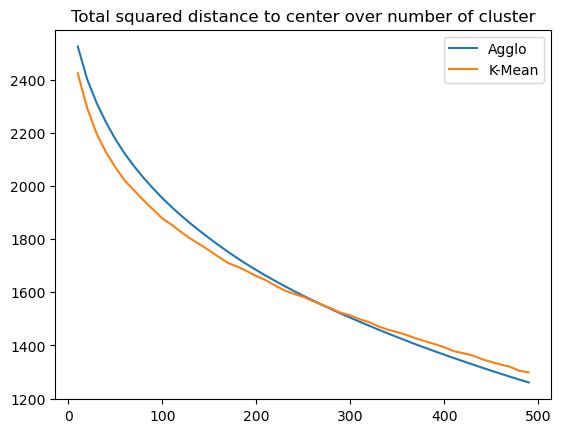

In [4]:
import numpy as np
from bertopic.dimensionality import BaseDimensionalityReduction
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

embedding_models = ["all-mpnet-base-v2"]


#Topic representation not tested yet

SEED = 100

np.random.seed(SEED)

sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)
pca_model = PCA(n_components=181)
embeddings = pca_model.fit_transform(embeddings)

total_squared_distances_for_each_try_agglo = []
total_squared_distances_for_each_try_kmeans = []

for n_cluster in range(10, 500, 10):
    print(n_cluster)
    clustering_method = AgglomerativeClustering(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    topic_embeddings = topic_model.topic_embeddings_
    docs_embeddings = embeddings

    have_outliers = int(-1 in topics) #This will be 1 if there is an outlier topic, just to cope with how topic_model.topic_embeddings_ is

    topics = np.array(topics)
    valid_points_mask = (topics != -1)
    valid_points = docs_embeddings[valid_points_mask]
    valid_assignments = topics[valid_points_mask]
    # Calculate the distances for each valid point to its assigned cluster center
    distances = np.linalg.norm(valid_points - topic_embeddings[valid_assignments + have_outliers], axis=1)
    total_squared_distances_for_each_try_agglo.append(np.dot(distances, distances))
################################################################################################################################################
    clustering_method = KMeans(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    topic_embeddings = topic_model.topic_embeddings_ #for every topic there is one vector
    docs_embeddings = embeddings

    have_outliers = int(-1 in topics) #This will be 1 if there is an outlier topic, just to cope with how topic_model.topic_embeddings_ is

    topics = np.array(topics)
    valid_points_mask = (topics != -1) #leaving -1 out
    valid_points = docs_embeddings[valid_points_mask]
    valid_assignments = topics[valid_points_mask]
    # Calculate the distances for each valid point to its assigned cluster center
    
    distances = np.linalg.norm(valid_points - topic_embeddings[valid_assignments + have_outliers], axis=1) 

    total_squared_distances_for_each_try_kmeans.append(np.dot(distances, distances))


import matplotlib.pyplot as plt 

plt.plot(range(10, 500, 10), total_squared_distances_for_each_try_agglo, label = "Agglo")
plt.plot(range(10, 500, 10), total_squared_distances_for_each_try_kmeans, label = "K-Mean")
plt.title("Total squared distance to center over number of cluster") 
plt.legend()
plt.show()

We locate the elbow point for the squared distance for the optimal number k.

In [7]:
from kneed import KneeLocator
kneedle = KneeLocator(range(10, 500, 10), total_squared_distances_for_each_try_kmeans, S=1.0, curve="convex", direction="decreasing", interp_method="polynomial")

print(round(kneedle.knee, 3))
print(round(kneedle.elbow, 3))

130
130


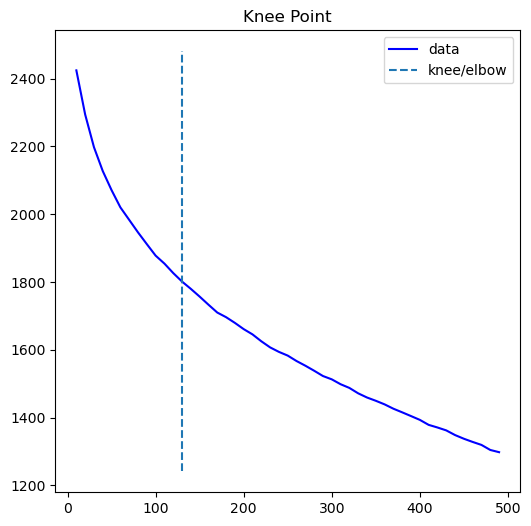

In [8]:
kneedle.plot_knee()

### Export results

After specifying the optimal k, we run and export the results for non-flattened data and 130-means clustering.

In [35]:
import numpy as np
from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.decomposition import PCA, TruncatedSVD
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, AgglomerativeClustering

embedding_models = ["all-mpnet-base-v2"]
mapping_methods_name = ["Not_Flattened"]
clustering_methods_name = ["K_means_130"]
#Topic representation not tested yet

SEED = 100

mapping_methods = [BaseDimensionalityReduction(),]

clustering_methods = [
    KMeans(n_clusters=130)
]
np.random.seed(SEED)

import itertools
for (embedding_model, mapping_methods_index, clustering_methods_index) in itertools.product(embedding_models, range(1), range(1)):
    print(f"Trial - Emdedding model: {embedding_model} - Mapping Method: {mapping_methods_name[mapping_methods_index]} - Clustering Method: {clustering_methods_name[clustering_methods_index]}")
    topic_model = BERTopic(hdbscan_model=clustering_methods[clustering_methods_index],
                           embedding_model=embedding_model,
                           umap_model=mapping_methods[mapping_methods_index])
    topics, probs = topic_model.fit_transform(docs)
    topic_model.get_document_info(docs).to_csv(f"./results_tuned/Topic_assignment_{embedding_model}_{mapping_methods_name[mapping_methods_index]}_{clustering_methods_name[clustering_methods_index]}.csv")

Trial - Emdedding model: all-mpnet-base-v2 - Mapping Method: Not_Flattened - Clustering Method: K_means_130


In [11]:
results = pd.read_csv("results_tuned\Topic_assignment_all-mpnet-base-v2_Not_Flattened_K_means_130.csv")
results.insert(1, "Keys", words["Keys"], True)
results 

,Unnamed: 0,Keys,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,0,a,final particle,97,97_particle_final_question_huh,"['particle', 'final', 'question', 'huh', 'mark...","['final particle', 'final question particle ',...",particle - final - question - huh - marker - m...,True
1,1,abĕn,"trousers, skirt",31,31_blanket_cloth_skirt_mat,"['blanket', 'cloth', 'skirt', 'mat', 'bag', 'p...","['cloth', 'a cloth ', 'thick paper, cloth, lips']",blanket - cloth - skirt - mat - bag - paper - ...,False
2,2,abĕn ao,clothes,31,31_blanket_cloth_skirt_mat,"['blanket', 'cloth', 'skirt', 'mat', 'bag', 'p...","['cloth', 'a cloth ', 'thick paper, cloth, lips']",blanket - cloth - skirt - mat - bag - paper - ...,False
3,3,"abêk, bongai abêk",person who laughs easily,113,113_morpheme_occurs_bound_surprise,"['morpheme', 'occurs', 'bound', 'surprise', 'e...",['(bound morpheme that occurs in tơlueng-tơluô...,morpheme - occurs - bound - surprise - express...,False
4,4,abŏu,edible snail,6,6_edible_seeds_plant_seed,"['edible', 'seeds', 'plant', 'seed', 'leaf', '...",['plant that edible seed and leaves the seed p...,edible - seeds - plant - seed - leaf - squash ...,False
...,...,...,...,...,...,...,...,...,...
3799,3799,yuh,"steam, smoke",78,78_wood_ashes_lighting_firewood,"['wood', 'ashes', 'lighting', 'firewood', 'cha...","['tobacco ashes, ashes flying from fire', 'to ...",wood - ashes - lighting - firewood - charcoal ...,False
3800,3800,yuh,"time, short period of time",76,76_time_period_ago_during,"['time', 'period', 'ago', 'during', 'night', '...","['time, short period of time', 'during that ti...",time - period - ago - during - night - day - p...,True
3801,3801,minh yuh,short period of time,76,76_time_period_ago_during,"['time', 'period', 'ago', 'during', 'night', '...","['time, short period of time', 'during that ti...",time - period - ago - during - night - day - p...,False
3802,3802,yuih,"to take down or take apart as a house, to take...",11,11_house_village_hut_porch,"['house', 'village', 'hut', 'porch', 'posts', ...","['village', 'village communal house ', 'large ...",house - village - hut - porch - posts - hammoc...,False


Random sampling of data for human scoring.

In [13]:
import pandas as pd
import numpy as np

# Initialize an empty list to store the selected rows
selected_rows = []

for topic in range(0, 130):
    rows_for_topic = results[results['Topic'] == topic].sample(10, replace=True)
    
    # Append the selected rows to the list
    selected_rows.append(rows_for_topic)

# Concatenate the selected rows into a new DataFrame
new_df = pd.concat(selected_rows)

# Reset the index of the new DataFrame
new_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
new_df


,Unnamed: 0,Keys,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,1357,iêl,smooth,0,0_happy_poor_brave_delicious,"['happy', 'poor', 'brave', 'delicious', 'must'...","['happy', 'very poor', 'happy ']",happy - poor - brave - delicious - must - faul...,False
1,719,đit,very mean,0,0_happy_poor_brave_delicious,"['happy', 'poor', 'brave', 'delicious', 'must'...","['happy', 'very poor', 'happy ']",happy - poor - brave - delicious - must - faul...,False
2,2062,lơliơ,"why, how, how come",0,0_happy_poor_brave_delicious,"['happy', 'poor', 'brave', 'delicious', 'must'...","['happy', 'very poor', 'happy ']",happy - poor - brave - delicious - must - faul...,False
3,377,"""băt",salty,0,0_happy_poor_brave_delicious,"['happy', 'poor', 'brave', 'delicious', 'must'...","['happy', 'very poor', 'happy ']",happy - poor - brave - delicious - must - faul...,False
4,3343,tơbăr,sticky,0,0_happy_poor_brave_delicious,"['happy', 'poor', 'brave', 'delicious', 'must'...","['happy', 'very poor', 'happy ']",happy - poor - brave - delicious - must - faul...,False
...,...,...,...,...,...,...,...,...,...
1295,3269,tê-lê,"Oh, shame on you",129,129_prohibited_taboo_customs_group,"['prohibited', 'taboo', 'customs', 'group', 'p...","['only those of one group, that group but no o...",prohibited - taboo - customs - group - permiss...,False
1296,3409,tơduă,"only those of one group, that group but no out...",129,129_prohibited_taboo_customs_group,"['prohibited', 'taboo', 'customs', 'group', 'p...","['only those of one group, that group but no o...",prohibited - taboo - customs - group - permiss...,True
1297,391,"""blaǐ-""blaǐ",don't dare,129,129_prohibited_taboo_customs_group,"['prohibited', 'taboo', 'customs', 'group', 'p...","['only those of one group, that group but no o...",prohibited - taboo - customs - group - permiss...,False
1298,391,"""blaǐ-""blaǐ",don't dare,129,129_prohibited_taboo_customs_group,"['prohibited', 'taboo', 'customs', 'group', 'p...","['only those of one group, that group but no o...",prohibited - taboo - customs - group - permiss...,False


In [45]:
new_df.to_csv("130topic_noflattening.csv")

## Further experiments on human-based analysis

TODO: Run the experiment again, with data flattened with PCA, number of dimensions specified above.

This step is procastinated as the scoring takes longer than expected.

## Interpretation of received scoring:

In [12]:
import pandas as pd
results = pd.read_csv("resources/130 Trangtinh - 130topic_noflattening_2.csv")

In [24]:
meaning_not_known = len(results.query("Tag == 'k'"))
incorrect_word = len(results.query("Tag == 'x'"))
total = len(results)

unknown_percentage = meaning_not_known/total*100
incorrect_percentage = incorrect_word/(total-meaning_not_known)*100

print("Unknown: ", unknown_percentage)

print("Incorrect: ", incorrect_percentage)

Unknown:  16.0
Incorrect:  15.384615384615385
